#Influenza Pandemic Prediction Model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import sklearn
import imblearn

loading data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from scipy.interpolate import CubicSpline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
#print the versions of libraries used
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Scikit-learn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)
print("xgboost:", xgb.__version__)

Pandas: 2.2.2
NumPy: 2.0.2
Scikit-learn: 1.6.1
imblearn: 0.13.0
xgboost: 2.1.4


In [82]:
pop_density_df = pd.read_excel('/content/pop-x1_timeseries_popdensity_timeseries_annual_2010-2100_mean_ssp245_gpw-v4_rev11_mean.xlsx')

temperature_df = pd.read_excel('/content/era5-x0.25_climatology_tas_climatology_monthly_1991-2020_mean_historical_era5_x0.25_mean.xlsx')
pig_vaccination_df = pd.read_csv('/content/pig_vaccination.csv')
poultry_deaths_df = pd.read_csv('/content/poultry_deaths.csv')
census_df = pd.read_excel('/content/2011-IndiaStateDist-0000.xlsx')
influenza_weekly_df = pd.read_csv('/content/influenza_weekly.csv')
india_influenza_df=influenza_weekly_df.query("Country=='India'").drop(columns=['ALL_INF2'],errors='ignore').copy()

<ipython-input-82-b63982c3c5bf>:7: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  influenza_weekly_df = pd.read_csv('/content/influenza_weekly.csv')


In [83]:
state_pop_density_df = pop_density_df.iloc[66:102].reset_index(drop=True)
pop_density_df = pop_density_df[66:102]
print(state_pop_density_df.tail())

        code                    name   2010-07   2020-07   2030-07   2040-07  \
31  IND.1155                   Bihar  1032.553  1181.669  1307.304  1409.450   
32  IND.1156              Chandigarh   243.860   273.954   298.760   317.870   
33  IND.1157            Chhattisgarh   208.230   237.395   261.949   282.019   
34  IND.1158  Dadra and Nagar Haveli   388.892   444.015   490.108   527.589   
35  IND.1159           Daman and Diu   324.992   364.361   396.975   421.702   

     2050-07   2060-07   2070-07   2080-07   2090-07   2100-07  
31  1483.014  1517.136  1511.505  1474.341  1411.256  1333.818  
32   330.350   334.120   329.541   318.683   302.969   284.774  
33   296.558   303.292   302.159   294.770   282.231   266.769  
34   554.482   566.540   563.733   549.172   525.011   495.495  
35   437.370   441.129   433.502   417.338   394.580   368.600  


In [84]:
print(f"India data shape: {india_influenza_df.shape}")
print(f"Temperature data shape: {temperature_df.shape}")
print(f"Population density data shape: {pop_density_df.shape}")
print(f"State population density data shape: {state_pop_density_df.shape}")
print(f"Pig vaccination data shape: {pig_vaccination_df.shape}")
print(f"Poultry deaths data shape: {poultry_deaths_df.shape}")
print(f"Census data shape: {census_df.shape}")


India data shape: (584, 22)
Temperature data shape: (148, 14)
Population density data shape: (36, 12)
State population density data shape: (36, 12)
Pig vaccination data shape: (20, 4)
Poultry deaths data shape: (14, 12)
Census data shape: (2028, 94)


In [85]:
print(india_influenza_df.isna().sum())
print(india_influenza_df.dtypes)

REPORT_ID              0
Country                0
WHOREGION              0
FLUREGION              0
Year                   0
Week                   0
SDATE                  0
EDATE                  0
SPEC_RECEIVED_NB      60
SPEC_PROCESSED_NB     23
AH1                  171
AH1N12009             49
AH3                   46
AH5                  197
ANOTSUBTYPED         196
INF_A                  0
BYAMAGATA            120
BVICTORIA            131
BNOTDETERMINED        31
INF_B                  0
ALL_INF                0
TITLE                  0
dtype: int64
REPORT_ID              int64
Country               object
WHOREGION             object
FLUREGION             object
Year                   int64
Week                   int64
SDATE                 object
EDATE                 object
SPEC_RECEIVED_NB     float64
SPEC_PROCESSED_NB    float64
AH1                  float64
AH1N12009            float64
AH3                  float64
AH5                  float64
ANOTSUBTYPED         float64
IN

In [86]:
# Filter rows where Name is uppercase (state-level data)
census_df['is_state'] = census_df['Name'].str.isupper()
state_rows = census_df[census_df['is_state']].copy()

In [87]:
andhra_pradesh_row = state_rows[state_rows['Name'] == 'ANDHRA PRADESH'].copy()

In [88]:
# Adding Telangana
total_ap_population_2011 = andhra_pradesh_row['TOT_P'].values[0]
telangana_population_2011 = 35600000
andhra_pradesh_population_2011 = total_ap_population_2011 - telangana_population_2011

# Create a new row for Telangana
telangana_row = andhra_pradesh_row.copy()
telangana_row['Name'] = 'TELANGANA'
telangana_row['TOT_P'] = telangana_population_2011

# Update Andhra Pradesh's population
andhra_pradesh_row['TOT_P'] = andhra_pradesh_population_2011

# Combine the adjusted rows with state_rows
state_rows = pd.concat([state_rows[state_rows['Name'] != 'ANDHRA PRADESH'],
                        andhra_pradesh_row,
                        telangana_row],
                       ignore_index=True)

In [89]:
# renaming column names for pop_density
state_pop_density_df = state_pop_density_df.rename(columns={
    '2010-07': 'pop_density_2010',
    '2020-07': 'pop_density_2020',
    '2030-07': 'pop_density_2030'
})

In [90]:
# Group by 'Name', take the first occurrence, reset index, and select/rename columns
state_population_2011 = state_rows.groupby('Name').first().reset_index()
state_population_2011 = state_population_2011[['Name', 'TOT_P']].rename(columns={'Name': 'name', 'TOT_P': 'population_2011'})

In [91]:
print("Columns before merge:", state_pop_density_df.columns)
columns_to_drop = [col for col in state_pop_density_df.columns if 'population_2011' in col]
if columns_to_drop:
    print(f"Dropping conflicting columns: {columns_to_drop}")
    state_pop_density_df = state_pop_density_df.drop(columns=columns_to_drop)

Columns before merge: Index(['code', 'name', 'pop_density_2010', 'pop_density_2020',
       'pop_density_2030', '2040-07', '2050-07', '2060-07', '2070-07',
       '2080-07', '2090-07', '2100-07'],
      dtype='object')


In [92]:
state_pop_density_df = state_pop_density_df.merge(state_population_2011, on='name', how='left')
state_pop_density_df['area'] = state_pop_density_df['population_2011'] / state_pop_density_df['pop_density_2010']

In [93]:
temperature_df=temperature_df.iloc[66:102].reset_index(drop=True)
temperature_df.tail()

,code,name,1991-01,1991-02,1991-03,1991-04,1991-05,1991-06,1991-07,1991-08,1991-09,1991-10,1991-11,1991-12
31,IND.1155,Bihar,15.78,19.75,25.35,30.04,31.42,31.01,29.41,29.23,28.54,26.38,21.90,17.32
32,IND.1156,Chandigarh,12.24,15.86,21.11,27.57,31.46,31.68,29.42,28.51,27.39,24.08,18.44,13.63
33,IND.1157,Chhattisgarh,19.22,22.63,27.01,30.81,32.94,29.80,26.56,26.09,26.38,25.16,22.03,19.14
34,IND.1158,Dadra and Nagar Haveli,21.99,23.65,26.74,28.68,29.74,28.40,26.57,26.17,26.64,27.46,26.00,23.30
35,IND.1159,Daman and Diu,22.60,23.66,26.13,28.02,29.06,28.81,27.51,26.95,27.42,28.35,26.79,24.12


In [94]:
# Identify monthly columns (1991-01 to 1991-12)
monthly_cols = [col for col in temperature_df.columns if col.startswith('1991-')]

# Calculate the annual average temperature per state by averaging the 12 monthly climatology values
temperature_df['avg_temperature'] = temperature_df[monthly_cols].mean(axis=1)

# Create a DataFrame with annual average temperature for each state and year (1991-2020)
states = temperature_df['name'].unique()
years = range(1991, 2021)  # 1991 to 2020
annual_temp_df = pd.DataFrame([(state, year) for state in states for year in years],
                              columns=['name', 'year'])
annual_temp_df = annual_temp_df.merge(temperature_df[['name', 'avg_temperature']],
                                      on='name', how='left')

# For the prediction dataset, use the same average temperature
historical_avg_temp = temperature_df[['name', 'avg_temperature']].copy()
historical_avg_temp = historical_avg_temp.rename(columns={'avg_temperature': 'historical_avg_temperature'})

In [95]:
jan_2009_temp = temperature_df[['name', '1991-01']].rename(columns={'1991-01': 'jan_2009_temperature'})
print("January 2009 Temperatures by State (using 1991-2020 climatology average for January):")
print(jan_2009_temp)

January 2009 Temperatures by State (using 1991-2020 climatology average for January):
                           name  jan_2009_temperature
0   Andaman and Nicobar Islands                 26.16
1                         Delhi                 13.24
2                           Goa                 24.41
3                       Gujarat                 20.13
4                       Haryana                 12.91
5              Himachal Pradesh                 -6.88
6             Jammu and Kashmir                -15.21
7                     Jharkhand                 16.20
8                     Karnataka                 23.16
9                        Kerala                 25.43
10                  Lakshadweep                 26.84
11               Andhra Pradesh                 23.47
12               Madhya Pradesh                 17.20
13                  Maharashtra                 21.63
14                      Manipur                 13.10
15                    Meghalaya                 14

In [96]:
# Filter for Indian data and drop unnecessary columns
india_influenza_df = influenza_weekly_df[influenza_weekly_df['Country'] == 'India'].copy()
india_influenza_df = india_influenza_df.drop(columns=['ALL_INF2'], errors='ignore')

# Identify outbreak rows based on the 'title' column (assuming 'Outbreak' indicates an outbreak)
india_influenza_df['is_outbreak'] = india_influenza_df['TITLE'].str.contains('Outbreak', case=False, na=False)

# Sum cases for outbreak years,
#  focusing on 2009 and 2010
outbreak_cases_2009_2010 = india_influenza_df[
    (india_influenza_df['is_outbreak']) &
    (india_influenza_df['Year'].isin([2009, 2010]))
]['ALL_INF'].sum()
print(f"Total Influenza Cases in India during 2009-2010 Outbreaks: {outbreak_cases_2009_2010}")

Total Influenza Cases in India during 2009-2010 Outbreaks: 9760


In [97]:
# Aggregate total cases annually for all years
annual_influenza_df = india_influenza_df.groupby('Year')['ALL_INF'].sum().reset_index()
annual_influenza_df = annual_influenza_df.rename(columns={'ALL_INF': 'annual_influenza_cases'})

In [98]:
# --- Process Pig Vaccination ---
pig_vaccination_df = pig_vaccination_df[['State/ UT', 'Number of Animal Vaccinated']]
pig_vaccination_df = pig_vaccination_df.rename(columns={
    'State/ UT': 'name',
    'Number of Animal Vaccinated': 'pig_vaccinated'
})
# --- Process Poultry Deaths ---
poultry_years = ['2018', '2019', '2020', '2021', '2022']
poultry_deaths_df = poultry_deaths_df.rename(columns={'State': 'name'})
for year in poultry_years:
    poultry_deaths_df[f'poultry_loss_{year}'] = poultry_deaths_df[f'{year} - Died'] + poultry_deaths_df[f'{year} - Culled']
poultry_loss_df = poultry_deaths_df.melt(id_vars=['name'],
                                         value_vars=[f'poultry_loss_{year}' for year in poultry_years],
                                         var_name='year', value_name='poultry_loss')
poultry_loss_df['year'] = poultry_loss_df['year'].str[-4:].astype(int)

# Creating our training dataset

In [99]:
# --- Create Training Dataset (1991-2020) ---
states = temperature_df['name'].unique()
years = range(1991, 2021)
base_df = pd.DataFrame([(state, year) for state in states for year in years], columns=['name', 'year'])

In [100]:
# Rename population density columns
pop_density_columns = {f"{year}-07": f"pop_density_{year}" for year in range(2010, 2101, 10)}
state_pop_density_df = state_pop_density_df.rename(columns=pop_density_columns)

In [101]:
def calculate_pop_density(row, year):
    # Define the available years
    density_years = list(range(2010, 2101, 10))  # [2010, 2020, 2030, ..., 2100]

    # If year is before 2010, use 2010 density
    if year <= 2010:
        return row['pop_density_2010']

    # If year is after 2100, use 2100 density
    if year >= 2100:
        return row['pop_density_2100']

    # Find the two closest years for interpolation
    for i in range(len(density_years) - 1):
        start_year = density_years[i]
        end_year = density_years[i + 1]
        if start_year <= year < end_year:
            start_density = row[f'pop_density_{start_year}']
            end_density = row[f'pop_density_{end_year}']
            # Linear interpolation
            fraction = (year - start_year) / (end_year - start_year)
            return start_density + (end_density - start_density) * fraction

    # This line should never be reached given the conditions above
    return row['pop_density_2010']

In [102]:
# Create a DataFrame with state names and areas
area_data = {
    'name': [
        'Andaman and Nicobar Islands', 'Delhi', 'Goa', 'Gujarat',
        'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
        'Karnataka', 'Kerala', 'Lakshadweep', 'Andhra Pradesh',
        'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
        'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan',
        'Arunachal Pradesh', 'Sikkim', 'Tamil Nadu', 'Telangana',
        'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Assam',
        'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadra and Nagar Haveli',
        'Daman and Diu'
    ],
    'area': [
        8249, 1483, 3702, 196024, 44212, 55673, 222236, 79714, 191791, 38863,
        32, 162968, 308245, 307713, 22327, 22429, 21081, 16579, 155707, 479,
        50362, 342239, 83743, 7096, 130058, 112077, 10486, 243286, 53483,
        88752, 78438, 94163, 114, 135191, 491, 112
    ]
}

area_df = pd.DataFrame(area_data)

# Check for duplicates in state_pop_density_df
duplicates = state_pop_density_df[state_pop_density_df.duplicated(subset=['name'], keep=False)]
if not duplicates.empty:
    print("Warning: Duplicate state names found in state_pop_density_df:")
    print(duplicates[['name']])
    # Keep the first occurrence of each state
    state_pop_density_df = state_pop_density_df.drop_duplicates(subset=['name'], keep='first')

# Reset the index to avoid duplicate labels
state_pop_density_df = state_pop_density_df.reset_index(drop=True)

# Merge the area data into state_pop_density_df
state_pop_density_df = state_pop_density_df.merge(area_df, on='name', how='left')

# Drop area_x and area_y if they exist, and rename the area column from area_df
if 'area_x' in state_pop_density_df.columns and 'area_y' in state_pop_density_df.columns:
    # Keep the manually inputted area (area_y) and drop the calculated area (area_x)
    state_pop_density_df = state_pop_density_df.drop(columns=['area_x'])
    state_pop_density_df = state_pop_density_df.rename(columns={'area_y': 'area'})
elif 'area' in state_pop_density_df.columns:
    # If only the original area exists (no conflict), drop it and keep the new area
    state_pop_density_df = state_pop_density_df.drop(columns=['area'], errors='ignore')
    state_pop_density_df = state_pop_density_df.rename(columns={'area_y': 'area'})
else:
    # If no area_x or area_y, just rename area_y to area
    state_pop_density_df = state_pop_density_df.rename(columns={'area_y': 'area'})

# Reset the index again after the merge to ensure no duplicate labels
state_pop_density_df = state_pop_density_df.reset_index(drop=True)

# Check for any missing areas
missing_areas = state_pop_density_df[state_pop_density_df['area'].isna()]
if not missing_areas.empty:
    print("Warning: The following states have missing area data:")
    print(missing_areas[['name']])

# Verify the columns in state_pop_density_df
print("Columns in state_pop_density_df after merge:")
print(state_pop_density_df.columns)


Columns in state_pop_density_df after merge:
Index(['code', 'name', 'pop_density_2010', 'pop_density_2020',
       'pop_density_2030', 'pop_density_2040', 'pop_density_2050',
       'pop_density_2060', 'pop_density_2070', 'pop_density_2080',
       'pop_density_2090', 'pop_density_2100', 'population_2011', 'area'],
      dtype='object')


In [103]:
# Merge features into base_df
base_df = base_df.merge(annual_temp_df, on=['name', 'year'], how='left')
base_df = base_df.merge(state_pop_density_df[['name', 'area'] + [f'pop_density_{year}' for year in range(2010, 2101, 10)]],
                        on='name', how='left')
base_df['pop_density'] = base_df.apply(lambda row: calculate_pop_density(row, row['year']), axis=1)
base_df['total_population'] = base_df['pop_density'] * base_df['area']

In [104]:
base_df['state_total_population'] = base_df['total_population']
base_df['state_pop_density'] = base_df['pop_density']

In [105]:
# Extract state population for 2009 and 2010
state_pop_2009 = base_df[base_df['year'] == 2009][['name', 'total_population']]
state_pop_2010 = base_df[base_df['year'] == 2010][['name', 'total_population']]
state_pop_2009_2010 = base_df[base_df['year'].isin([2009, 2010])].groupby('name')['total_population'].mean().reset_index()
state_pop_2009_2010 = state_pop_2009_2010.rename(columns={'total_population': 'avg_population_2009_2010'})
print("\nAverage State Population for 2009-2010:")
print(state_pop_2009_2010.sort_values(by='name'))


Average State Population for 2009-2010:
                           name  avg_population_2009_2010
0   Andaman and Nicobar Islands              1.047376e+05
1                Andhra Pradesh              4.765266e+07
2             Arunachal Pradesh              3.982817e+06
3                         Assam              2.344386e+07
4                         Bihar              9.722829e+07
5                    Chandigarh              2.780004e+04
6                  Chhattisgarh              2.815082e+07
7        Dadra and Nagar Haveli              1.909460e+05
8                 Daman and Diu              3.639910e+04
9                         Delhi              1.377663e+06
10                          Goa              5.239959e+05
11                      Gujarat              5.484007e+07
12                      Haryana              2.327974e+07
13             Himachal Pradesh              5.854127e+06
14            Jammu and Kashmir              3.497328e+07
15                    Jharkhand

In [106]:
# Compute average pop_density for 2009-2010 per state
state_pop_density_2009_2010 = base_df[base_df['year'].isin([2009, 2010])].groupby('name')['pop_density'].mean().reset_index()
state_pop_density_2009_2010 = state_pop_density_2009_2010.rename(columns={'pop_density': 'avg_pop_density_2009_2010'})

# Merge with state population
state_data_2009_2010 = state_pop_2009_2010.merge(state_pop_density_2009_2010, on='name', how='left')
state_data_2009_2010['pop_density_factor'] = state_data_2009_2010['avg_pop_density_2009_2010'] / state_data_2009_2010['avg_pop_density_2009_2010'].max()

# Use pop_density_factor as the risk weight (normalize to sum to 1)
state_data_2009_2010['risk_weight'] = state_data_2009_2010['pop_density_factor'] / state_data_2009_2010['pop_density_factor'].sum()

# Distribute outbreak_cases_2009_2010 to states based on risk_weight
state_data_2009_2010['estimated_cases_2009_2010'] = outbreak_cases_2009_2010 * state_data_2009_2010['risk_weight']
state_data_2009_2010['threshold_ratio_2009_2010'] = state_data_2009_2010['estimated_cases_2009_2010'] / state_data_2009_2010['avg_population_2009_2010']

# Print the new thresholds
print("\nState-Specific Case-to-Population Ratio Thresholds for 2009-2010 (Based on Population Density):")
print(state_data_2009_2010[['name', 'threshold_ratio_2009_2010']].sort_values(by='name'))


State-Specific Case-to-Population Ratio Thresholds for 2009-2010 (Based on Population Density):
                           name  threshold_ratio_2009_2010
0   Andaman and Nicobar Islands                   0.000094
1                Andhra Pradesh                   0.000005
2             Arunachal Pradesh                   0.000009
3                         Assam                   0.000010
4                         Bihar                   0.000008
5                    Chandigarh                   0.006821
6                  Chhattisgarh                   0.000006
7        Dadra and Nagar Haveli                   0.001584
8                 Daman and Diu                   0.006943
9                         Delhi                   0.000524
10                          Goa                   0.000210
11                      Gujarat                   0.000004
12                      Haryana                   0.000018
13             Himachal Pradesh                   0.000014
14            Jamm

In [107]:
# Normalize pop_density
base_df['pop_density_factor'] = base_df['pop_density'] / base_df['pop_density'].max()

# Compute the total risk per year (sum of pop_density_factor for all states in each year)
total_risk_per_year = base_df.groupby('year')['pop_density_factor'].sum().reset_index()
total_risk_per_year.rename(columns={'pop_density_factor': 'total_risk'}, inplace=True)

# Merge total_risk into base_df
base_df = base_df.merge(total_risk_per_year, on='year', how='left')

# Compute risk weight per state
base_df['risk_weight'] = base_df['pop_density_factor'] / base_df['total_risk']

# Compute the average pop_density_factor for 2009-2010 per state
avg_pop_density_factor_2009_2010 = (
    base_df[base_df['year'].isin([2009, 2010])]
    .groupby('name')['pop_density_factor']
    .mean()
    .reset_index()
    .rename(columns={'pop_density_factor': 'avg_pop_density_factor_2009_2010'})
)

# Merge avg_pop_density_factor_2009_2010 into base_df
base_df = base_df.merge(avg_pop_density_factor_2009_2010, on='name', how='left')

# Compute the pop_density scaling factor
base_df['pop_density_scaling_factor'] = (
    base_df['pop_density_factor'] / base_df['avg_pop_density_factor_2009_2010']
).fillna(1.0)  # Default to 1 if no historical data is available

# Merge estimated cases from state_data_2009_2010
if 'state_data_2009_2010' in globals():  # Ensure the dataset exists
    base_df = base_df.merge(
        state_data_2009_2010[['name', 'estimated_cases_2009_2010']],
        on='name',
        how='left'
    )

# Estimate state-level cases per year using the scaling factor
base_df['estimated_cases'] = (
    base_df['estimated_cases_2009_2010'] * base_df['pop_density_scaling_factor']
).fillna(0)

# Update allocated_cases based on estimated_cases
base_df['allocated_cases'] = base_df['estimated_cases']

# Handle missing risk_weight values
if 'risk_weight_2009_2010' in base_df.columns:
    base_df['risk_weight'] = base_df['risk_weight'].combine_first(base_df['risk_weight_2009_2010'])
    base_df.drop(columns=['risk_weight_2009_2010'], inplace=True)

# Ensure outbreak_cases_2009_2010 exists before using it
if 'outbreak_cases_2009_2010' in globals() and 'case_scaling_factor' in base_df.columns:
    base_df['estimated_cases'] = (
        outbreak_cases_2009_2010 * base_df['risk_weight'] * base_df['case_scaling_factor']
    ).fillna(0)


In [108]:
base_df['allocated_cases'] = base_df['estimated_cases']

In [109]:
# Merge static pig vaccination data
base_df = base_df.merge(pig_vaccination_df, on='name', how='left')

# Merge poultry loss, using average of 2018-2020 for years before 2018
base_df = base_df.merge(poultry_loss_df, on=['name', 'year'], how='left')
avg_poultry_loss = poultry_loss_df[poultry_loss_df['year'].between(2018, 2020)]\
                    .groupby('name')['poultry_loss'].mean().reset_index()
avg_poultry_loss = avg_poultry_loss.rename(columns={'poultry_loss': 'avg_poultry_loss'})
base_df = base_df.merge(avg_poultry_loss, on='name', how='left')
base_df['poultry_loss'] = base_df['poultry_loss'].fillna(base_df['avg_poultry_loss'])
base_df = base_df.drop(columns=['avg_poultry_loss'])

In [110]:
base_df.state_total_population.describe()


,state_total_population
count,1.050000e+03
mean,3.469609e+07
std,4.187381e+07
min,2.780004e+04
25%,1.437381e+06
50%,2.432354e+07
75%,5.484007e+07
max,2.053803e+08


In [112]:
# Normalize pig vaccination and poultry deaths (per capita)
base_df['pig_vaccination_rate'] = base_df['pig_vaccinated'] / base_df['state_total_population']
base_df['poultry_loss_rate'] = base_df['poultry_loss'] / base_df['state_total_population']
base_df['poultry_loss_rate_lag'] = base_df.groupby('name')['poultry_loss_rate'].shift(1)
# correlation_matrix = base_df[['allocated_cases', 'pig_vaccination_rate', 'poultry_loss_rate_lag']].corr(method='spearman')
# print(correlation_matrix)

# Analyze correlation with influenza cases
correlation_df = base_df[['allocated_cases', 'avg_temperature', 'state_total_population', 'pig_vaccinated','poultry_loss']].dropna()
correlation_matrix = correlation_df.corr(method='spearman')
print("Correlation Matrix ")
print(correlation_matrix)

Correlation Matrix 
                        allocated_cases  avg_temperature  \
allocated_cases                1.000000        -0.465255   
avg_temperature               -0.465255         1.000000   
state_total_population         0.652364         0.021667   
pig_vaccinated                -0.195399        -0.250000   
poultry_loss                  -0.204011         0.215406   

                        state_total_population  pig_vaccinated  poultry_loss  
allocated_cases                       0.652364       -0.195399     -0.204011  
avg_temperature                       0.021667       -0.250000      0.215406  
state_total_population                1.000000       -0.141270     -0.096313  
pig_vaccinated                       -0.141270        1.000000     -0.042525  
poultry_loss                         -0.096313       -0.042525      1.000000  


In [113]:
# Remove national columns from base_df
base_df = base_df.drop(columns=['national_population', 'national_pop_density', 'national_area', 'annual_influenza_cases'], errors='ignore')

# Update monthly_df (remove national data and update allocated cases)
# --- Expand base_df to Monthly Frequency ---
states = base_df['name'].unique()
years = base_df['year'].unique()
months = range(1, 13)  # Months 1 to 12

# Create a MultiIndex with all combinations of name, year, and month
index = pd.MultiIndex.from_product([states, years, months], names=['name', 'year', 'month'])
monthly_df = pd.DataFrame(index=index).reset_index()

# Merge all annual data from base_df into monthly_df (excluding national data)
annual_columns = [
    'pop_density', 'avg_temperature', 'pig_vaccinated', 'poultry_loss',
    'pig_vaccination_rate', 'poultry_loss_rate', 'area', 'total_population',
    'allocated_cases'
]
monthly_df = monthly_df.merge(
    base_df[['name', 'year'] + annual_columns],
    on=['name', 'year'],
    how='left'
)

In [114]:
# --- Add Monthly Temperature Data ---
monthly_temp_cols = [f'1991-{str(m).zfill(2)}' for m in range(1, 13)]
temperature_melted = temperature_df.melt(
    id_vars=['name'],
    value_vars=monthly_temp_cols,
    var_name='month_str',
    value_name='monthly_temperature'
)
temperature_melted['month'] = temperature_melted['month_str'].str[-2:].astype(int)
temperature_melted = temperature_melted.drop(columns=['month_str'])

# Merge monthly temperature into monthly_df
monthly_df = monthly_df.merge(
    temperature_melted,
    on=['name', 'month'],
    how='left'
)

# --- Distribute Annual Allocated Cases to Monthly ---
monthly_df['monthly_allocated_cases'] = monthly_df['allocated_cases'] / 12
monthly_df['monthly_case_to_pop_ratio'] = monthly_df['monthly_allocated_cases'] / monthly_df['total_population']

# --- Add total_state_population ---
monthly_df = monthly_df.merge(
    base_df[['name', 'year', 'state_total_population']],
    on=['name', 'year'],
    how='left'
)

# --- Define High-Risk State ---
# Step 1: Label all state-months in 2009-2010 as high-risk (1)
monthly_df['high_risk_state'] = ((monthly_df['year'] == 2009) | (monthly_df['year'] == 2010)).astype(int)

# Step 2: Simulate high-risk scenarios in other years
# Select 5% of state-months outside 2009-2010 randomly
non_pandemic_df = monthly_df[(monthly_df['year'] != 2009) & (monthly_df['year'] != 2010)]
simulated_high_risk_indices = non_pandemic_df.sample(frac=0.05, random_state=42).index

# Compute the average allocated_cases during 2009-2010 per state
avg_allocated_cases_2009_2010 = monthly_df[
    monthly_df['high_risk_state'] == 1
].groupby('name')['allocated_cases'].mean().reset_index()
avg_allocated_cases_2009_2010 = avg_allocated_cases_2009_2010.rename(
    columns={'allocated_cases': 'avg_allocated_cases_2009_2010'}
)

# Merge this into monthly_df
monthly_df = monthly_df.merge(avg_allocated_cases_2009_2010, on='name', how='left')

# For simulated high-risk state-months, scale allocated_cases to 2009-2010 levels
monthly_df.loc[simulated_high_risk_indices, 'allocated_cases'] = monthly_df.loc[
    simulated_high_risk_indices, 'avg_allocated_cases_2009_2010'
]

# Update monthly_allocated_cases and monthly_case_to_pop_ratio for simulated high-risk state-months
monthly_df.loc[simulated_high_risk_indices, 'monthly_allocated_cases'] = (
    monthly_df.loc[simulated_high_risk_indices, 'allocated_cases'] / 12
)
monthly_df.loc[simulated_high_risk_indices, 'monthly_case_to_pop_ratio'] = (
    monthly_df.loc[simulated_high_risk_indices, 'monthly_allocated_cases'] /
    monthly_df.loc[simulated_high_risk_indices, 'state_total_population']
)

# Label these simulated high-risk state-months as 1
monthly_df.loc[simulated_high_risk_indices, 'high_risk_state'] = 1

# --- Verify the Distribution ---
print("Value counts in high_risk_state:\n", monthly_df['high_risk_state'].value_counts())
print("Percentage of high-risk state-months:",
      (monthly_df['high_risk_state'].mean() * 100).round(2), "%")

Value counts in high_risk_state:
 high_risk_state
0    11491
1     1469
Name: count, dtype: int64
Percentage of high-risk state-months: 11.33 %


In [115]:
monthly_df=monthly_df[monthly_df['year']>2006]
monthly_df.tail()

,name,year,month,pop_density,avg_temperature,pig_vaccinated,poultry_loss,pig_vaccination_rate,poultry_loss_rate,area,total_population,allocated_cases,monthly_temperature,monthly_allocated_cases,monthly_case_to_pop_ratio,state_total_population,high_risk_state,avg_allocated_cases_2009_2010
12955,Daman and Diu,2020,8,364.361,26.618333,NaN,NaN,NaN,NaN,112,40808.432,283.323916,26.95,23.610326,0.000579,40808.432,0,252.710927
12956,Daman and Diu,2020,9,364.361,26.618333,NaN,NaN,NaN,NaN,112,40808.432,283.323916,27.42,23.610326,0.000579,40808.432,0,252.710927
12957,Daman and Diu,2020,10,364.361,26.618333,NaN,NaN,NaN,NaN,112,40808.432,283.323916,28.35,23.610326,0.000579,40808.432,0,252.710927
12958,Daman and Diu,2020,11,364.361,26.618333,NaN,NaN,NaN,NaN,112,40808.432,252.710927,26.79,21.059244,0.000516,40808.432,1,252.710927
12959,Daman and Diu,2020,12,364.361,26.618333,NaN,NaN,NaN,NaN,112,40808.432,283.323916,24.12,23.610326,0.000579,40808.432,0,252.710927


In [151]:
monthly_df.columns

Index(['name', 'year', 'month', 'pop_density', 'avg_temperature',
       'pig_vaccinated', 'poultry_loss', 'pig_vaccination_rate',
       'poultry_loss_rate', 'area', 'total_population', 'allocated_cases',
       'monthly_temperature', 'monthly_allocated_cases',
       'monthly_case_to_pop_ratio', 'state_total_population',
       'high_risk_state', 'avg_allocated_cases_2009_2010'],
      dtype='object')

In [116]:
monthly_df.high_risk_state.value_counts()

,count
high_risk_state,
0,4923
1,1125


# Model Training

In [153]:
# Select relevant columns for training, including 'name'
final_columns = [
    'name', 'monthly_temperature', 'pig_vaccinated', 'area',
    'state_total_population', 'monthly_case_to_pop_ratio', 'high_risk_state'
]
training_df = monthly_df[final_columns].copy()

# Feature Engineering: Add population density
training_df['pop_density'] = training_df['state_total_population'] / training_df['area']

# Define features and target
features = [
    'monthly_temperature', 'pig_vaccinated', 'area',
    'state_total_population', 'monthly_case_to_pop_ratio', 'pop_density'
]
X = training_df[features + ['name']]  # Include 'name' for encoding
y = training_df['high_risk_state']

# One-hot encode the 'name' column
X_encoded = pd.get_dummies(X, columns=['name'], drop_first=True)

# Handle missing values with mean imputation for numeric features
imputer = SimpleImputer(strategy='median')
X_numeric = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

In [157]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define XGBoost classifier
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Hyperparameter tuning with GridSearchCV to optimize F1-score
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_smote, y_train_smote)

# Best model from grid search
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


#Evaluating Model

In [158]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle


Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       985
           1       0.54      0.98      0.69       225

    accuracy                           0.84      1210
   macro avg       0.77      0.89      0.79      1210
weighted avg       0.91      0.84      0.85      1210

AUC-ROC: 0.8681489001692048
Confusion Matrix (Default Threshold):
[[794 191]
 [  4 221]]

Feature Importance:
                        Feature  Importance
39             name_Uttarakhand    0.142082
6           name_Andhra Pradesh    0.079767
30                  name_Odisha    0.051203
24          name_Madhya Pradesh    0.043817
9                    name_Bihar    0.041374
4     monthly_case_to_pop_ratio    0.039839
15                     name_Goa    0.038727
35              name_Tamil Nadu    0.037278
31              name_Puducherry    0.036194
3        state_total_population    0.035931
5                   pop_density    

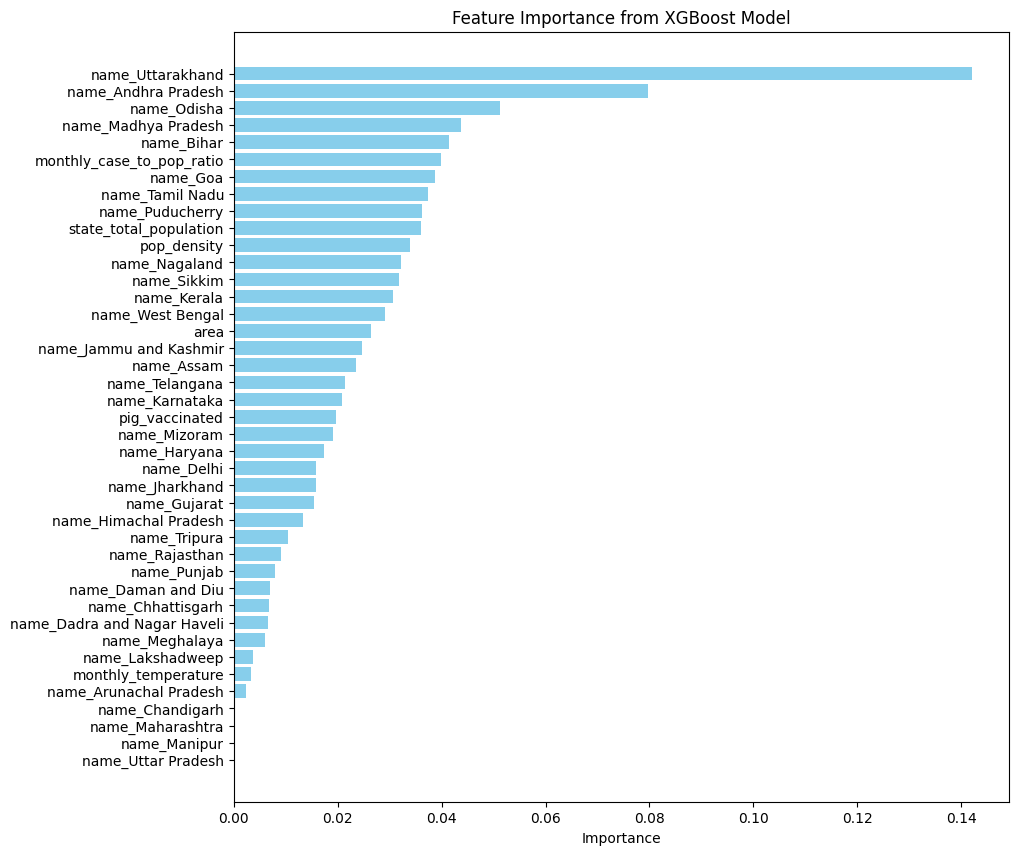

In [159]:
# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate with default threshold
print("\nClassification Report (Default Threshold):")
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix (Default Threshold):")
print(confusion_matrix(y_test, y_pred))

# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X_numeric.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 10))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [160]:
#saving training_df as csv
with open('training_df.csv', 'w') as f:
    training_df.to_csv(f, index=False)

In [161]:
with open('xgboost high risk model', 'wb') as file:
    pickle.dump(best_model, file)
print(f"\nModel saved successfully")


Model saved successfully
